# Category Embedding

In [1]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import l2
from keras.optimizers import *
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 
import xgboost as xgb

Using TensorFlow backend.


## Data Analysis:

In [2]:
train = pd.read_csv("../input/train.csv")
print("shape of train : ",train.shape)

shape of train :  (201917, 6)


In [3]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [24]:
test = pd.read_csv("../input/test.csv")
print("shape of test : ",test.shape)



shape of test :  (123623, 5)


In [25]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [6]:
merchants = pd.read_csv("../input/merchants.csv")
print("shape of merchants : ",merchants.shape)
merchants.head()


shape of merchants :  (334696, 22)


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [4]:
historical_transactions = pd.read_csv("../input/historical_transactions.csv")
historical_transactions.drop(['authorized_flag','category_1','installments','category_3','category_2','state_id','subsector_id','city_id'],axis = 1, inplace = True)
print("shape of merchants : ",historical_transactions.shape)
historical_transactions.head()

shape of merchants :  (29112361, 6)


,card_id,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,C_ID_4e6213e9bc,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07
1,C_ID_4e6213e9bc,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45
2,C_ID_4e6213e9bc,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29
3,C_ID_4e6213e9bc,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26
4,C_ID_4e6213e9bc,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19


In [8]:
new_merchant_transactions = pd.read_csv("../input/new_merchant_transactions.csv")
print("shape of merchants : ",new_merchant_transactions.shape)
new_merchant_transactions.head()

shape of merchants :  (1963031, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [32]:
cardCountTrain = train['card_id'].unique().size
print(cardCountTrain)
print(train['card_id'].size)
cardCountTest = test['card_id'].unique().size
print(cardCountTest)
print(test['card_id'].size)

201917
201917
123623
123623


every value of card_id in Train and test is unique.

In [31]:
cardCountTransactions = historical_transactions['card_id'].unique().size
print(cardCountTransactions)


325540


we see that: cardCountTrain + cardCountTest = cardCountTransactions,
Lets try to join the dataframes to get all the values.

Lets see the correlation of the features 1,2,3 with the target.

In [36]:
import seaborn as sns 

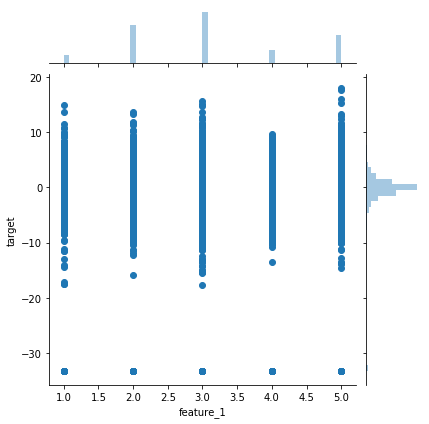

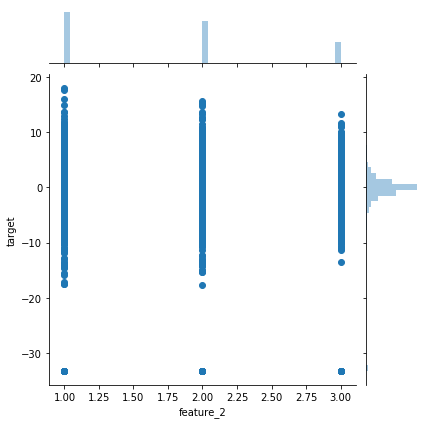

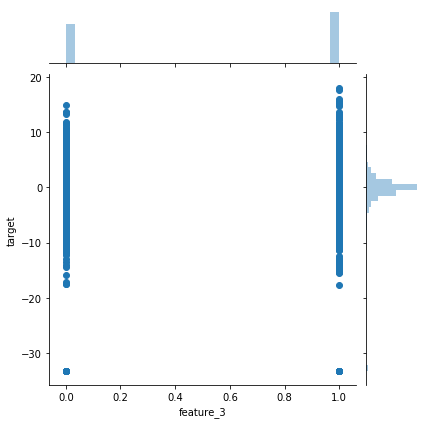

In [38]:
sns.jointplot(x=train['feature_1'], y=train['target'], data=train)  
plt.show()

sns.jointplot(x=train['feature_2'], y=train['target'], data=train)  
plt.show()

sns.jointplot(x=train['feature_3'], y=train['target'], data=train)  
plt.show()

In [26]:
print('unique merchant_id : {0}'.format(historical_transactions['merchant_id'].nunique()))
print('unique merchant_category_id : {0}'.format(historical_transactions['merchant_category_id'].nunique()))
print('unique month_lag : {0}'.format(historical_transactions['month_lag'].nunique()))
print('unique purchase_date : {0}'.format(historical_transactions['purchase_date'].nunique()))
print('unique purchase_amount : {0}'.format(historical_transactions['purchase_amount'].nunique()))

unique merchant_id : 326311
unique merchant_category_id : 327
unique month_lag : 14
unique purchase_date : 16395300
unique purchase_amount : 215014


Lets look at some features from other datasets. We can merge the transactions dataset with the train to see how other features correlate with target.


In [5]:
joinedTrain = pd.merge(train, historical_transactions, sort=False, left_on = 'card_id', right_on = 'card_id')
joinedTrain.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11
1,2017-06,C_ID_92a2005557,5,2,1,-0.820283,278,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00
2,2017-06,C_ID_92a2005557,5,2,1,-0.820283,683,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16
3,2017-06,C_ID_92a2005557,5,2,1,-0.820283,309,M_ID_b790230ee9,-2,-0.610167,2017-12-15 12:06:58
4,2017-06,C_ID_92a2005557,5,2,1,-0.820283,278,M_ID_ab67f6c982,-7,-0.307232,2017-07-08 15:13:18


In [6]:
joinedTrain.dropna(inplace=True)
joinedTrain.shape


(17943982, 11)

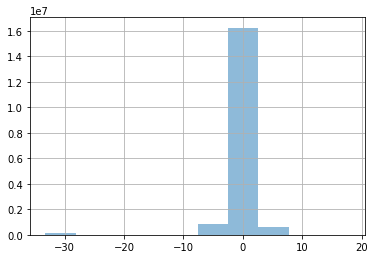

In [7]:
joinedTrain['target'].hist(alpha=0.5)

In [8]:
from sklearn import preprocessing

target = joinedTrain['target'].values
min_max_scaler = preprocessing.MinMaxScaler()
normalizedTarget = min_max_scaler.fit_transform(target.reshape(-1, 1))

In [123]:
normalizedTarget

array([[0.63298643],
       [0.63298643],
       [0.63298643],
       ...,
       [0.6126847 ],
       [0.6126847 ],
       [0.6126847 ]])

In [9]:
first_active_month = {p:i for (i,p) in enumerate(joinedTrain['first_active_month'].unique())}
card_id = {p:i for (i,p) in enumerate(joinedTrain['card_id'].unique())}
feature_1 = {p:i for (i,p) in enumerate(joinedTrain['feature_1'].unique())}
feature_2 = {p:i for (i,p) in enumerate(joinedTrain['feature_2'].unique())}
feature_3 = {p:i for (i,p) in enumerate(joinedTrain['feature_3'].unique())}
merchant_category_id = {p:i for (i,p) in enumerate(joinedTrain['merchant_category_id'].unique())}
merchant_id = {p:i for (i,p) in enumerate(joinedTrain['merchant_id'].unique())}
month_lag = {p:i for (i,p) in enumerate(joinedTrain['month_lag'].unique())}
purchase_amount = {p:i for (i,p) in enumerate(joinedTrain['purchase_amount'].unique())}
purchase_date = {p:i for (i,p) in enumerate(joinedTrain['purchase_date'].unique())}


In [10]:
processed_data = joinedTrain.loc[:,['first_active_month','card_id','feature_1','feature_2',
                                    'feature_3','merchant_category_id','merchant_id','month_lag',
                                   'purchase_amount','purchase_date']].copy()
processed_data['first_active_month'] = [first_active_month[x] for x in joinedTrain['first_active_month']]
processed_data['card_id'] = [card_id[x] for x in joinedTrain['card_id']]
processed_data['feature_1'] = [feature_1[x] for x in joinedTrain['feature_1']]
processed_data['feature_2'] = [feature_2[x] for x in joinedTrain['feature_2']]
processed_data['feature_3'] = [feature_3[x] for x in joinedTrain['feature_3']]
processed_data['merchant_category_id'] = [merchant_category_id[x] for x in joinedTrain['merchant_category_id']]
processed_data['merchant_id'] = [merchant_id[x] for x in joinedTrain['merchant_id']]
processed_data['month_lag'] = [month_lag[x] for x in joinedTrain['month_lag']]
processed_data['purchase_amount'] = [purchase_amount[x] for x in joinedTrain['purchase_amount']]
processed_data['purchase_date'] = [purchase_date[x] for x in joinedTrain['purchase_date']]


In [12]:
first_active_inp = Input(shape=(1,),dtype='int64')
card_inp = Input(shape=(1,),dtype='int64')
f1_inp = Input(shape=(1,),dtype='int64')
f2_inp = Input(shape=(1,),dtype='int64')
f3_inp = Input(shape=(1,),dtype='int64')
mcid_inp = Input(shape=(1,),dtype='int64')
mid_inp = Input(shape=(1,),dtype='int64')
month_lag_inp = Input(shape=(1,),dtype='int64')
p_amount_inp = Input(shape=(1,),dtype='int64')
p_date_inp = Input(shape=(1,),dtype='int64')

first_active_emb = Embedding(len(first_active_month),5,input_length=1, embeddings_regularizer=l2(1e-6))(first_active_inp)
card_emb = Embedding(len(card_id),5,input_length=1, embeddings_regularizer=l2(1e-6))(card_inp)
f1_emb = Embedding(len(feature_1),5,input_length=1, embeddings_regularizer=l2(1e-6))(f1_inp)
f2_emb = Embedding(len(feature_2),5,input_length=1, embeddings_regularizer=l2(1e-6))(f2_inp)
f3_emb = Embedding(len(feature_3),1,input_length=1, embeddings_regularizer=l2(1e-6))(f3_inp)
mcid_emb = Embedding(len(merchant_category_id),5,input_length=1, embeddings_regularizer=l2(1e-6))(mcid_inp)
mid_emb = Embedding(len(merchant_id),5,input_length=1, embeddings_regularizer=l2(1e-6))(mid_inp)
month_lag_emb = Embedding(len(month_lag),5,input_length=1, embeddings_regularizer=l2(1e-6))(month_lag_inp)
p_amount_emb = Embedding(len(purchase_amount),5,input_length=1, embeddings_regularizer=l2(1e-6))(p_amount_inp)
p_date_emb = Embedding(len(purchase_date),5,input_length=1, embeddings_regularizer=l2(1e-6))(p_date_inp)

In [13]:
print(mid_inp)

Tensor("input_7:0", shape=(?, 1), dtype=int64)


In [14]:
x = concatenate([first_active_emb,card_emb,f1_emb,f2_emb,f3_emb,mcid_emb,mid_emb,month_lag_emb,p_amount_emb,p_date_emb])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(2,activation='softmax')(x)
nn_model = Model([first_active_inp,card_inp,f1_inp,f2_inp,f3_inp,mcid_inp,mid_inp,month_lag_inp,p_amount_inp,p_date_inp],x)
nn_model.compile(loss = 'sparse_categorical_crossentropy',optimizer='RMSProp')

In [15]:
nn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

In [16]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split

def set_callbacks(description='run1',patience=15,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint('best_model_weights_{}.h5'.format(description),save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)   
#     cycl = CyclicLR(max_lr=0.03,step_size=5000)
    cb = [cp,es,rlop]
    return cb

features = processed_data.columns
kf = StratifiedKFold(n_splits=5,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(processed_data, normalizedTarget, test_size=0.2)


In [17]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(14355185, 10)
(3588797, 10)
(14355185, 1)
(3588797, 1)


In [19]:
nn_model.fit([X_train[f] for f in features],y_train,epochs=5, validation_data=[[X_val[f] for f in features],y_val],callbacks=set_callbacks())


Train on 14355185 samples, validate on 3588797 samples
Epoch 1/5
  541824/14355185 [>.............................] - ETA: 205:49:26 - loss: 1.2866e-04

KeyboardInterrupt: 

In [ ]:
nn_model.load_weights('./best_model_weights_run1.h5')
from sklearn.metrics import confusion_matrix, roc_auc_score
preds = nn_model.predict([X_val[f] for f in features])
roc_auc_score(y_val,preds[:,1])

## ML Benchmark:

In [ ]:
from sklearn.linear_model import LinearRegression

mlTrain = train.drop('target', axis = 1)
mlTrain = mlTrain.drop('first_active_month', axis = 1)
mlTarget = train['target']
lm = LinearRegression()
#lm.fit(mlTrain,mlTarget)